In [193]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.special import jv, yv
import matplotlib.pyplot as plt
import mpmath
from scipy.integrate import quad
from scipy.special import kn, k1
from scipy.special import zeta
# Physical constants (natural units: GeV, s^-1)
M_pl = 2.435e18          # Planck mass [GeV]
fermi_constant = 1.166e-5           # Fermi constant [GeV^-2]
m_N = 0.1 # HNL Mass in GeV
m_a = 1e-6 # ALP mass in GeV
mixing_parameter_squared = 1e-10 # active-sterile neutrino sector mixing
f_a = 1e3 # ALP decay constant scenario 1
g_star = 106.75

#f_M = 0.1 # in GeV

Light Neutrino Mass Deppisch 2024 \
$m_\nu =  |U_{eN}|^2 m_N$


In [194]:
m_nu = mixing_parameter_squared*m_N

In [195]:
z_init = 1e-4
z_final = 1e2
mass_temp_ratio=  np.linspace(z_init,z_final, 1000)

Decay Width of $N \rightarrow a \nu$ Deppisch 2024 equation 2.21 \
$\Gamma_{N \rightarrow a \nu} = \frac{|U_{eN}|^2 m_{N}^3}{4 \pi f_{a}^2} \sqrt{1+ (\frac{m_a}{m_N})^2}(1-(\frac{m_a}{m_N})^2)^\frac{3}{2}$

In [196]:
def decay_width_N_av(f_a,m_N,mixing_parameter_squared, m_a):
    decay_width_N_av = mixing_parameter_squared*(m_N**3)*(1/(4*np.pi*(f_a**2)))*(np.sqrt(1+ (m_a/m_N)**2))*((1-(m_a/m_N)**2)**1.5)
    return decay_width_N_av


$\Gamma_{a \rightarrow \nu \nu} = \frac{1}{f_{a}^2} \frac{m_{N}^2 m_a |U_{eN}|^4}{2 \pi} \sqrt{1 - \frac{4 m_{\nu}^2 }{m_{a}^2}} (1 - \frac{2 m_{\nu}^2}{m_{a}^2})$

In [197]:
def decay_width_a_vv(f_a, m_N, mixing_parameter_squared, m_a, m_v):
    decay_width_a_vv = (1/(2* np.pi * f_a**2))*m_N**2 * m_a *( mixing_parameter_squared**2) * (np.sqrt(1- (4*m_nu**2)/m_a**2)) * (1- (2*m_nu**2)/m_a**2)
    #decay_width_a_vv = ((m_N**2 )* m_a * (mixing_parameter_squared**2))/(2* np.pi * f_a**2)
    return decay_width_a_vv

Thermally Averaged Cross-Section Density Equation 3.4 Deppisch et al 2024.

$\gamma_{X_1 X_2 \leftrightarrow Y_1 Y_2} = \frac{T}{64 \pi^4} \int^{\infty}_{s_{min}} s^{\frac{1}{2}} \hat{\sigma} (s) K_1 (\frac{\sqrt{s}}{T}) ds$

rewritten in terms of

$T = \frac{m_N}{z}$

$\gamma_{X_1 X_2 \leftrightarrow Y_1 Y_2} = \frac{m_N}{64 z \pi^4} \int^{\infty}_{s_{min}} s^{\frac{1}{2}} \hat{\sigma} (s) K_1 (\frac{ z \sqrt{s}}{m_N}) ds$

Where $\hat{\sigma} (s) = 2 s \sigma (s) \lambda (1, {m_{X_{1}}}^{2} /{s}, {m_{X_{2}}}^{2} / {s})$ is the reduced cross-section

Where $\lambda (a,b,c) = (a-b-c)^2  -4bc$ 

The minimum value of the integral is defined as

$s_{min} = Max[(m_{X_1} + m_{X_2})^2 , (m_{Y_1} + m_{Y_2})^2]$

In [198]:
def lambda_func(a, b, c):
        return (a - b - c)**2 - 4*b*c

In [199]:
def reduced_sigma(s):

        sigma_val = cross_section_aa_vN(m_N, m_a, mixing_parameter_squared, s, f_a)
        

        lam = lambda_func(1, m_a**2/s, m_a**2/s)
  
        return 2 * s * sigma_val * lam

Starting with the $aa \rightarrow \nu N$ process - A.7 of Deppisch et al 2024.

The cross-section is defined as
$\sigma_{a a \to N N} = \frac{2 m_N^4 \sqrt{s - 4 m_a^2} U_{eN}^2}{\pi f_a^4 s^{3/2}} \left[ - \frac{2(2m_a^4 - 7m_a^2 m_N^2 + 5m_N^4 + m_N^2 s)}{m_a^4 - 2m_a^2 m_N^2 + m_N^4 + m_N^2 s} + \frac{4(2m_a^2 - 4m_N^2 - s) \coth^{-1}\left(\frac{2(m_a^2 - m_N^2) - s}{\sqrt{s - 4m_a^2}\sqrt{s}}\right)}{\sqrt{s - 4m_a^2}\sqrt{s}} \right]$


In [200]:
def cross_section_aa_vN(m_N, m_a,mixing_parameter_squared,s, f_a): #A.7 of paper
    

    sqrt_s_minus_4ma2 = np.sqrt(s - 4 * m_a**2)
    sqrt_s = np.sqrt(s)
    # prefactor
    prefactor_numerator = 2*m_N**4 * sqrt_s_minus_4ma2 * mixing_parameter_squared
    prefactor_denominator = np.pi*f_a**4 *s**1.5
    prefactor = prefactor_numerator/prefactor_denominator
    termA_numerator = -2*(2*m_a**4 - 7*m_a**2 * m_N**2 + 5*m_N**4 + m_N**2 *s)
    termA_denominator = m_a**4 - 2*m_a**2 *m_N**2 + m_N**4 + m_N**2 *s
    termA = termA_numerator/ termA_denominator
    coth_term_numerator = 2*(m_a**2 - m_N**2) - s
    coth_term_denominator = sqrt_s_minus_4ma2 *sqrt_s
    coth_term = mpmath.acoth(coth_term_numerator/coth_term_denominator)
    termB_numerator = 4*(2*m_a**2 - 4*m_N**2 -s)*coth_term
    termB_denominator = sqrt_s_minus_4ma2 * sqrt_s
    termB = termB_numerator/termB_denominator
    cross_section = prefactor*(termA + termB)
    return cross_section

In [201]:
def gamma_aa_vN(z, m_N, m_a, mixing_parameter_squared, f_a):

   
    s_min = max((4.1*m_a)**2, (4.1*m_N)**2)

    #s_max = (100*(m_N/z))**2  # Safe upper bound where K₁ decays sufficiently
    s_max = np.inf


    def lambda_func(a, b, c):
        return (a - b - c)**2 - 4*b*c
    

    def reduced_sigma(s):

        sigma_val = cross_section_aa_vN(m_N, m_a, mixing_parameter_squared, s, f_a)
        

        lam = lambda_func(1, m_a**2/s, m_a**2/s)
  
        return 2 * s * sigma_val * lam
    

    def integrand(s):
        # Handle snear zero to avoid numerical issues
        if s <= 0:
            return 0.0
        return np.sqrt(s) * reduced_sigma(s) * k1(np.sqrt(s)/(m_N/z))
    

    # below format ignores error value as integrand produces result and error
    integral, _ = quad(integrand, s_min, s_max, 
                      epsabs=1e-9, epsrel=1e-6, 
                      limit=1000)
    

    gamma = ((m_N/z) / (64 * np.pi**4)) * integral
    return gamma


Baumann Cosmology Equation 3.55

Hubble Parameter $H^2 = \frac{\pi^2}{90} g_* \frac{T^4}{M_{pl}^{2}}$ 
$\rightarrow H = \frac{\pi}{M_{pl}} * \sqrt{\frac{g_*}{90}}* (\frac{m_N}{z})^2$

In [202]:
def H(z):
    H = (np.pi/M_pl)*(np.sqrt(g_star/90))*((m_N/z)**2)
    return H

Entropy Density - Baumann 3.50

$s = \Sigma_i \frac{\rho_i + P_i}{T} = \frac{2 \pi^2}{45}*g_{*s}(T)*T^3$

$s = \frac{2 \pi^2}{45}*g_{*s} * (\frac{m_N}{z})^3 $

In [203]:
gamma_N_av_n_N_eq_ratio_list = [] 
gamma_a_vv_n_N_eq_ratio_list = []
H_list = []
gamma_aa_vN_list = []
aa_vN_ratio_list = []
n_a_eq_list = []


In [204]:
def entropy_density(z):
    entropy_density = ((2*(np.pi**2))/(45))*g_star*((m_N/z)**3)
    return entropy_density

Temporary non-relativistic species density

In [205]:
def equilibrium_species_density(g,mass,z):
    species_density = g*(mass**3)*(1/(2*(np.pi**2)*(z)))*kn(2,z)
    return species_density 

However for Figure 4 of Deppisch 2024, the y axis is plotting \

$\gamma_{X \rightarrow Y_1 ...}/ n^{eq}_X$ \
Hence, in equation form this can be written simply as 

$\gamma_{X \rightarrow Y_1 ...}/ n^{eq}_X = \frac{K_{1}}{K_{2}}\Gamma_X  $

In [206]:
for z in mass_temp_ratio:
    
  
    gamma_N_av_n_N_eq_ratio_value =  decay_width_N_av(1e3,m_N,mixing_parameter_squared, m_a)*(kn(1,z)/kn(2,z))
    gamma_N_av_n_N_eq_ratio_list.append(gamma_N_av_n_N_eq_ratio_value)
    gamma_a_vv_n_N_eq_ratio_value = decay_width_a_vv(f_a, m_N, mixing_parameter_squared, m_a, m_nu)*(kn(1,z)/kn(2,z))
    gamma_a_vv_n_N_eq_ratio_list.append(gamma_a_vv_n_N_eq_ratio_value)
    H_value = H(z)
    H_list.append(H_value)




    

Below I evaluate the cross-section Terms starting with A.7

In [207]:
for z in mass_temp_ratio:
    
    gamma_aa_vN_value = gamma_aa_vN(z, m_N, m_a, mixing_parameter_squared, f_a)
    gamma_aa_vN_list.append(gamma_aa_vN_value)
    n_a_eq_value = equilibrium_species_density(1, m_a, z)
    n_a_eq_list.append(n_a_eq_value)
    aa_vN_ratio_value = gamma_aa_vN_value/ n_a_eq
    aa_vN_ratio_list.append(gamma_aa_vN_value)

In [208]:
print(gamma_aa_vN_list)

[np.float64(5.427307787133458e-20), np.float64(7.913543479679695e-29), np.float64(3.5440538320123605e-30), np.float64(5.286546031667962e-31), np.float64(1.2754660834175798e-31), np.float64(3.974258495213093e-32), np.float64(1.448884191587184e-32), np.float64(5.868793444201387e-33), np.float64(2.5625691870563374e-33), np.float64(1.183381443185488e-33), np.float64(5.706267824992658e-34), np.float64(2.8476109308043798e-34), np.float64(1.4611685744278611e-34), np.float64(7.672098397466615e-35), np.float64(4.1069408254270204e-35), np.float64(2.2349146813406044e-35), np.float64(1.2335203601506017e-35), np.float64(6.892409004583037e-36), np.float64(3.8929387473720705e-36), np.float64(2.2198383505140423e-36), np.float64(1.2765756214411496e-36), np.float64(7.397209764583164e-37), np.float64(4.315758628844651e-37), np.float64(2.5335652936699213e-37), np.float64(1.4957146517243454e-37), np.float64(8.875535831402503e-38), np.float64(5.291556806448124e-38), np.float64(3.168483558260501e-38), np.flo

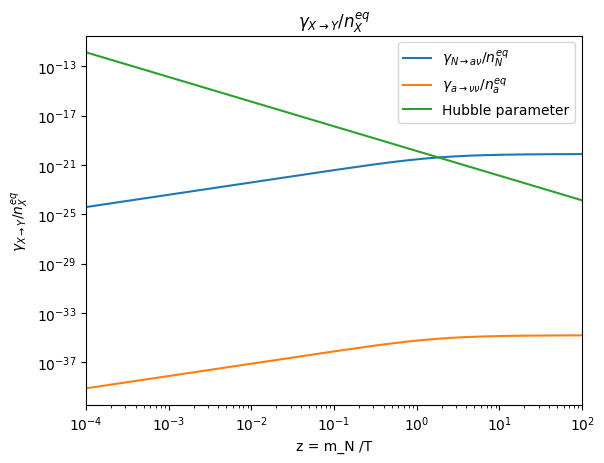

[np.float64(1.4051205786466133e-12), np.float64(1.3995169129272527e-18), np.float64(3.5022867063523875e-19), np.float64(1.5570900790142807e-19), np.float64(8.760089704639571e-20), np.float64(5.607017398724463e-20), np.float64(3.8940213684074465e-20), np.float64(2.8610497385054174e-20), np.float64(2.1905693506570208e-20), np.float64(1.730868252991329e-20), np.float64(1.4020344064907024e-20), np.float64(1.1587271655887116e-20), np.float64(9.73667424156457e-21), np.float64(8.296444064521251e-21), np.float64(7.153645092538783e-21), np.float64(6.231679010718409e-21), np.float64(5.477107224346022e-21), np.float64(4.851729233202843e-21), np.float64(4.3276509355700495e-21), np.float64(3.8841193747204324e-21), np.float64(3.505436165924719e-21), np.float64(3.1795490621574454e-21), np.float64(2.8970809919976585e-21), np.float64(2.650647895268524e-21), np.float64(2.4343712009088925e-21), np.float64(2.2435239693827393e-21), np.float64(2.074270400681855e-21), np.float64(1.923471579720655e-21), np.fl

In [209]:
plt.loglog(mass_temp_ratio, gamma_N_av_n_N_eq_ratio_list, label = r'$\gamma_{N \rightarrow a \nu }/ n_{N}^{eq}$')
plt.loglog(mass_temp_ratio, gamma_a_vv_n_N_eq_ratio_list,label = r'$\gamma_{a \rightarrow \nu \nu }/ n_{a}^{eq}$' )
plt.loglog(mass_temp_ratio, H_list, label = 'Hubble parameter' )
plt.xlim(1e-4, 1e2)
plt.title(r'$\gamma_{X \rightarrow Y }/ n_{X}^{eq}$')
plt.xlabel("z = m_N /T")
plt.ylabel(r'$\gamma_{X \rightarrow Y }/ n_{X}^{eq}$')
plt.legend()
plt.show()
print(H_list)

